# Analysis of Pitchfork album reviews and song lyrics
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time
import os

FS = 16 # fontsize
%matplotlib inline
plt.style.use('seaborn')

In [3]:
# Change the default Seaborn parameters
sns.set_context("notebook", font_scale=2, rc={"font.size":10, "axes.labelsize":25})

### Load the Pitchfork reviews and song lyrics

In [4]:
# Pitchfork album reviews
reviews = pd.read_json('./data/pitchfork_reviews_matched.json')
reviews = reviews[reviews.gender != 'multiple']
reviews = reviews[['artist', 'album', 'year', 'genre',
                   'gender', 'score', 'best_new_music',
                   'abstract', 'editorial', 'label', 'url', 'cover']]

# Load the song lyrics
songs = pd.read_json('./data/songs_with_reviews.json')
songs = songs[songs.gender != 'multiple']
songs = songs[['title', 'artist', 'album', 'year', 'genre',
               'gender', 'lyrics', 'image']]

In [5]:
reviews.head(1)

,artist,album,year,genre,gender,score,best_new_music,abstract,editorial,label,url,cover
0,Kanye West,Graduation,2007,rap,male,8.7,1,Though it doesn't quite match\n ...,While rap music famously thrives on the kind o...,Roc-A-Fella\n / \n ...,/reviews/albums/10658-graduation/,https://media.pitchfork.com/photos/5929b270ea9...


In [6]:
songs.head(2)

,title,artist,album,year,genre,gender,lyrics,image
0,2 of Amerikaz Most Wanted,2Pac,All Eyez on Me,1996-05-07,rap,male,Up out of there\nAin't nothin' but a gangsta p...,https://images.genius.com/e47c72fcb1f2756daafc...
1,Ain't Hard 2 Find,2Pac,All Eyez on Me,1996-02-13,rap,male,"They say\nInfluenced by crime, addicted to gri...",https://images.genius.com/e47c72fcb1f2756daafc...


# Exploratory analysis

In [7]:
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255

### How many reviews do we have for each artist?

In [71]:
artists = reviews.groupby('artist')

Total number of artists: 119
Total number of reviews: 523
Median of 3 reviews per artist.


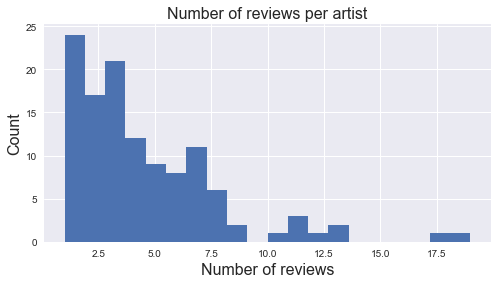

In [92]:
print("Total number of artists: {}".format(len(artists)))
print("Total number of reviews: {}".format(len(reviews)))
print("Median of {:1.0f} reviews per artist.".format(np.median(artists.count())))

# Histogram of the number of reviews per artist
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(artists.count()['album'], 20)
ax.set_xlabel("Number of reviews", fontsize=FS)
ax.set_ylabel("Count", fontsize=FS)
ax.set_title("Number of reviews per artist", fontsize=FS)
plt.show()

## Do review scores depend on the album publication year?

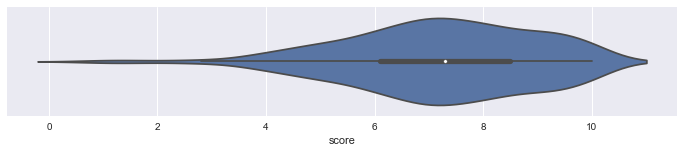

In [144]:
# Distribution of review scores
fig, ax = plt.subplots(figsize=(12, 2))
sns.violinplot(x="score", data=reviews)
plt.show()

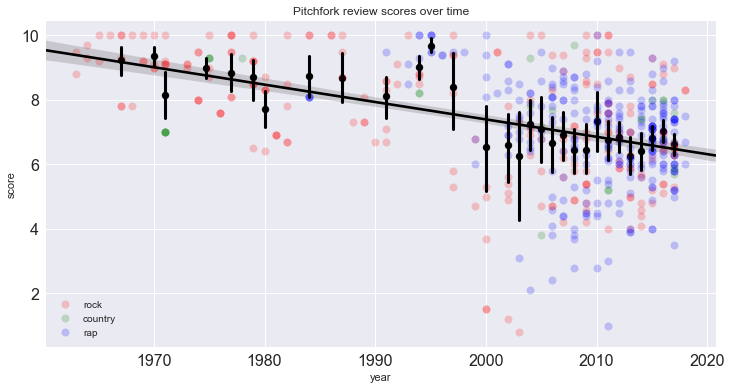

In [143]:
# Average score over time
fig, ax = plt.subplots(figsize=(12, 6))
params = {'alpha': 0.2, 'title': 'Pitchfork review scores over time', 'figsize': (12, 6),
          'linestyle': '', 'marker': 'o', 'ms': 8, 'fontsize': FS, 'legend': False, 'ax':ax}

# Scatter plots grouped by genre
colors = ['r', 'g', 'b']
for genre, color in zip(set(reviews.genre), colors):
    reviews[reviews.genre==genre].plot(x='year', y='score', kind='line', color=color, **params, label=genre)

# Regression plot
sns.regplot('year', 'score', data=reviews, x_bins=len(set(reviews.year)), ax=ax, color='k')

plt.legend()

plt.show()

## Are there any patterns in review scores when grouped by *genre*?

In [8]:
genres = reviews.groupby('genre')

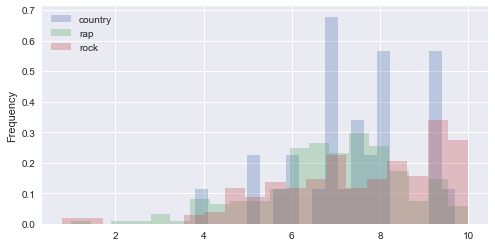

In [10]:
genres.score.plot(kind='hist', alpha=0.3, figsize=(8, 4), legend=True, density=True, bins=20);

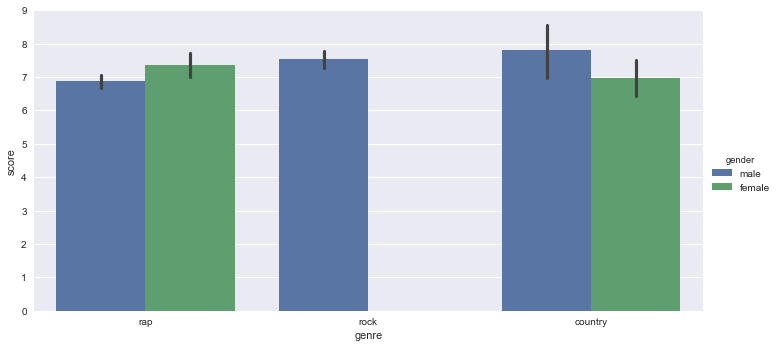

In [147]:
# Review score broken down by genre and artist gender
sns.factorplot('genre', 'score', 'gender', data=reviews, kind='bar', size=5, aspect=2, legend=True)

## Are there patterns in review scores when grouped by *gender*?

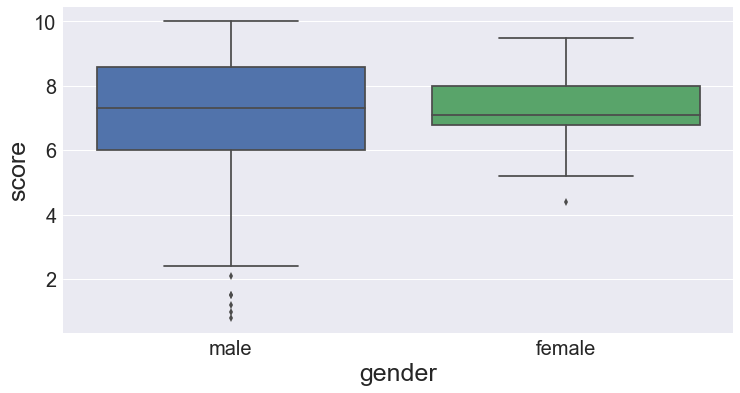

In [157]:
fig, ax = plt.subplots(figsize=(12, 6))
params = {'notch':False, 'saturation':0.8}
sns.boxplot('gender', 'score', data=reviews, ax=ax, **params)
plt.show()

## How do *genre* and *gender* effect the relationship between *score* and *year*?

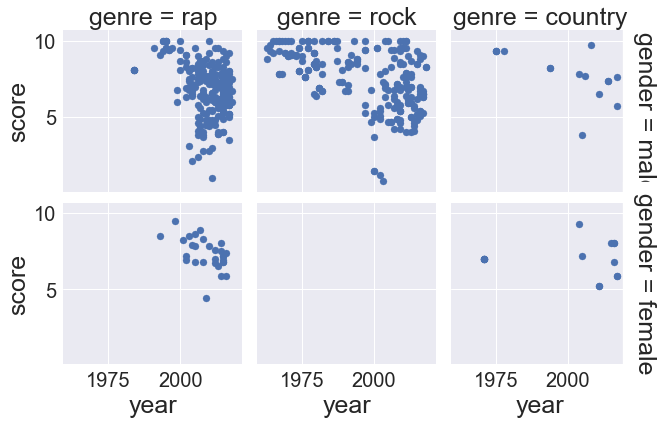

In [166]:
g = sns.FacetGrid(reviews, row="gender", col="genre", margin_titles=True)
g.map(plt.scatter, "year", "score")
plt.show()

## Reviews grouped by score

In [ ]:
s = reviews.where(reviews.score>=9)
s.dropna(inplace=True)

# Calculating lexical diversity

In [14]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
punctuation = "".join([symbol for symbol in punctuation if symbol not in ["'", '"']])
punctuation += '–'

In [78]:
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def tokenizeText(txt, remove_stop_words=True):
    """Splits a string of text into individual words"""
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = [w for w in clean_str(txt).split() if w not in stop_words]
    return words

def lexdiv(s, *args):
    tokens = tokenizeText(s, *args)
    return len(set(tokens))/max(len(tokens), 1)

### Add lexical diversity values to the DataFrames

In [79]:
# Reviews
lexical_diversities = list(map(lexdiv, reviews.editorial))
reviews['lexdiv'] = lexical_diversities

# Songs
lexical_diversities = list(map(lexdiv, songs.lyrics))
songs['lexdiv'] = lexical_diversities

## Is lexical diversity of the Pitchfork review correlated with the album's lexical diversity?

In [12]:
albums = songs.groupby(['artist', 'album'])

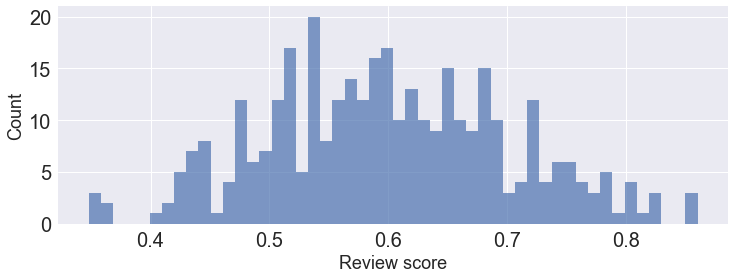

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
albums['lexdiv'].mean().plot.hist(bins=50, alpha=0.7, ax=ax)
ax.set_xlabel("Review score", fontsize=FS+2)
ax.set_ylabel("Count", fontsize=FS+2)
plt.show()

Looks like there isn't any relationship between an album's average lyrical diversity and its review's lyrical diversity

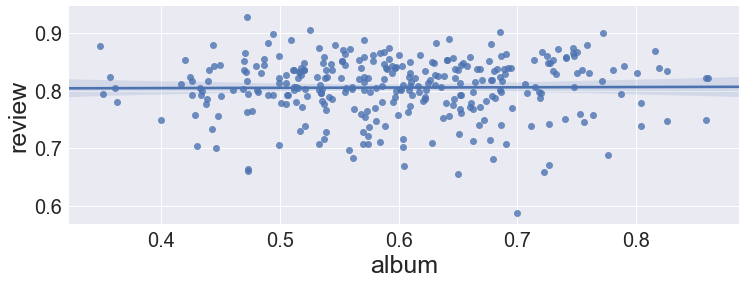

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
sns.regplot('album', 'review', data=ld, ax=ax)
plt.show()

### Merge together overlapping reviews and songs 

In [80]:
albums_by_artist = songs.groupby(['artist', 'album'])
combo = pd.merge(albums_by_artist.mean(), reviews, on=['artist', 'album'], suffixes=['_a', '_r'])

In [81]:
combo.head(1)

,artist,album,lexdiv_a,year,genre,gender,score,best_new_music,abstract,editorial,label,url,cover,lexdiv_r
0,2 Chainz,Based on a T.R.U. Story,0.570859,2012,rap,male,4.5,0,"Once you understand the 2 Chainz persona, ther...","At this point, the artist formerly known as Ti...",Def Jam,/reviews/albums/17092-based-on-a-tru-story/,https://media.pitchfork.com/photos/5929bf885e6...,0.822764


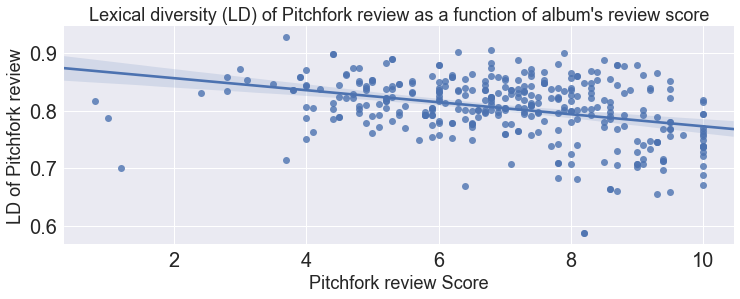

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
sns.regplot('score', 'lexdiv_r', data=combo, ax=ax)

ax.set_title("Lexical diversity (LD) of Pitchfork review as a function of album's review score", fontsize=FS+2)
ax.set_xlabel("Pitchfork review Score", fontsize=FS+2)
ax.set_ylabel("LD of Pitchfork review", fontsize=FS+2)
plt.show()

Well this is interesting. It looks like there is a slight negative correlation between an album's review score and the lexical diversity of its corresponding review on Pitchfork

In [140]:
ax.get_ylim()

(0.6308621181101058, 0.945284969543555)

In [ ]:
sns.regplot

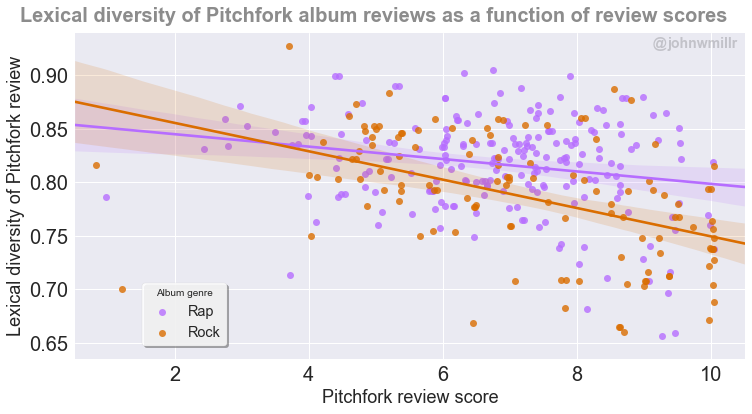

In [167]:
fig, ax = plt.subplots(figsize=(12, 6))
for g, c in zip(['rap', 'rock'], colors[:2]):
    sns.regplot('score', 'lexdiv_r', data=combo[combo.genre==g], color=c, ax=ax, label=(g[0].upper() + g[1:]),
               order=1, x_jitter=0.05)

title = "Lexical diversity of Pitchfork album reviews as a function of review scores"
ax.text(-0.3, 0.95, title, fontsize=FS+4, ha='left', color='gray', weight='heavy', alpha=0.9)
ax.text(9.13, 0.93, "@", fontsize=FS-2, alpha=0.2, va='center', weight='heavy')
ax.text(10.4, 0.93, "johnwmillr", fontsize=FS-2, alpha=0.2, ha='right', va='center', weight='heavy')
ax.set_xlabel("Pitchfork review score", fontsize=FS+2)
ax.set_ylabel("Lexical diversity of Pitchfork review", fontsize=FS+2)
params = {'frameon':True, 'shadow':True, 'fontsize':'x-large', 'facecolor':'white',
          'title':'Album genre', 'framealpha':0.85}
ax.legend(loc=(0.1, 0.04), **params)
ax.set_ylim((0.635, 0.94))
# plt.show()

plt.savefig('./figures/lexdiv_album_reviews.png', dpi=300, bbox_inches='tight')

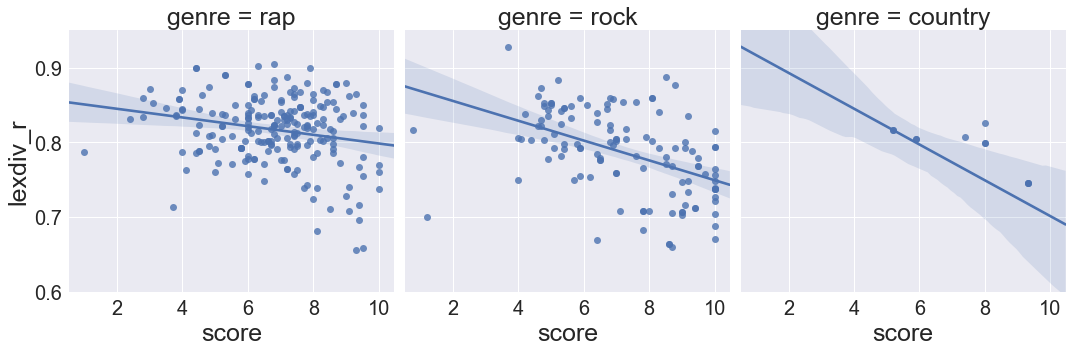

In [51]:
g = sns.FacetGrid(combo, col="genre", margin_titles=True, size=5, sharey=True)
g.map(sns.regplot, "score", "lexdiv_r")
plt.ylim((0.6, 0.95))
plt.show()

## Is the length of the album review related to album year? Or album score?

In [21]:
reviews['word_count'] = [len(tokens) for tokens in map(tokenizeText, reviews.editorial)]

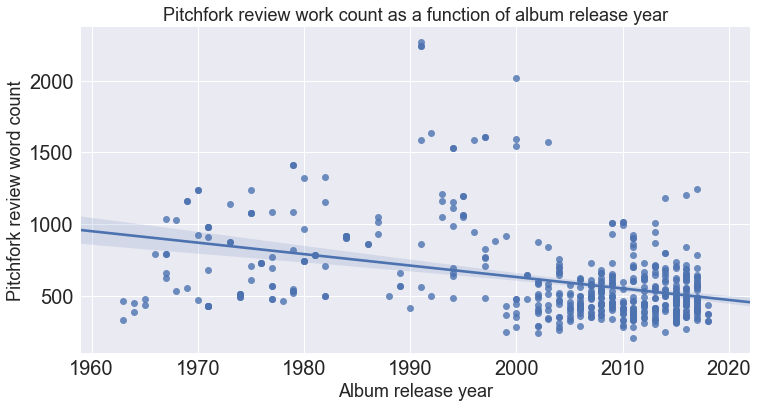

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot('year', 'word_count', data=reviews, ax=ax)
ax.set_title("Pitchfork review work count as a function of album release year", fontsize=FS+2)
ax.set_xlabel("Album release year", fontsize=FS+2)
ax.set_ylabel("Pitchfork review word count", fontsize=FS+2)
plt.show()

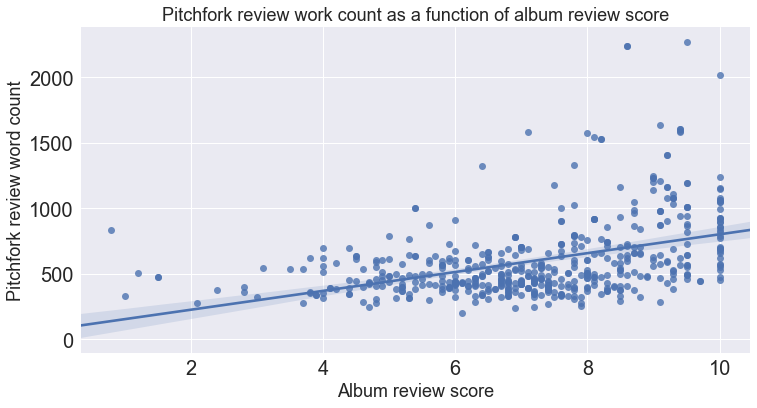

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot('score', 'word_count', data=reviews, ax=ax)
ax.set_title("Pitchfork review work count as a function of album review score", fontsize=FS+2)
ax.set_xlabel("Album review score", fontsize=FS+2)
ax.set_ylabel("Pitchfork review word count", fontsize=FS+2)
plt.show()

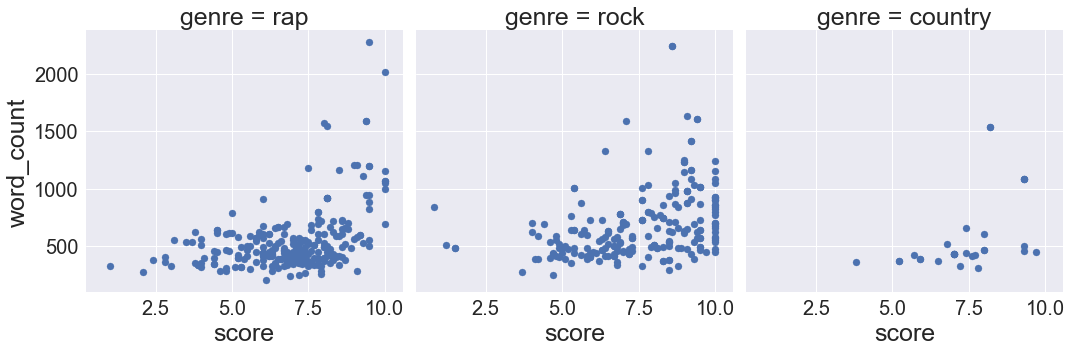

In [43]:
g = sns.FacetGrid(reviews, col="genre", margin_titles=True, size=5)
g.map(plt.scatter, "score", "word_count")
plt.show()

---
# Interactive plots

## Interactive plot that shows review abstract with mouse over

In [16]:
# Album cover should pop up

## Pitchfork Review scores as a function of lexical diversity

In [43]:
import mpld3
from mpld3 import plugins
%matplotlib inline
mpld3.enable_notebook()

In [20]:
# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: center;
}
img
{
    border-radius: 8px;
    height: auto;        
}
center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
"""

In [82]:
# Create the data tips
names = combo.artist.values
imgs = ['<img src="{}" width="80">'.format(url) for url in combo.cover]
labels = []
for i in range(len(combo)):
    label = combo.iloc[[i], :].T    
    label.columns = [names[i]]
    html = label.drop(['best_new_music', 'abstract', 'editorial', 'url', 'cover'], axis=0).to_html() + '\n' + imgs[i]
    labels.append(html)

In [83]:
# Scatter plot the data
ms = 9
fig, ax = plt.subplots(figsize=(10,8))
ax.grid(True, alpha=0.3)

x, y = combo.lexdiv_a, combo.score
b = []
for genre, color in zip(set(combo.genre), colors):
    b.append(plt.plot(x[combo.genre==genre], y[combo.genre==genre], 'o',
                      color=color, ms=ms, alpha=0.7, label=genre))

# https://mpld3.github.io/examples/html_tooltips.html
points = ax.plot(combo.lexdiv_a, combo.score, 'ko', mec='k', ms=ms, alpha=0.0, label="") # Plot all of the data
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

ax.set_xlabel("Lexical diversity (album lyrics)", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
# ax.annotate("@johnwmillr", (0.17,1), fontsize=FS-4, alpha=0.5)
params = {'alpha':0.3, 'va':'center', 'ha':'right', 'weight':'heavy', 'fontsize':FS-2}
ax.text(0.815, 0.65, "@", **params)
ax.text(0.88, 0.65, "johnwmillr", **params)

ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)

mpld3.display()
# plotname = 'mpld3_{}_vs_{}'.format('lexdiv','score')
# mpld3.save_html(fig, './figures/'+plotname+'.html', figid=plotname, template_type='simple')

---
# Misc work

In [199]:
all_reviews['Radiohead'][0]

Review('Radiohead', 'In Rainbows', 'Radiohead', 'In Rainbows [CD 2]', 'Radiohead%20In%20Rainbows', '/reviews/albums/10988-in-rainbows-cd-2/', "<class 'bs4.BeautifulSoup'>")

In [182]:
print(all_reviews['Pink Floyd'][-1].score())
print(all_reviews['Pink Floyd'][-1].cover())

5.7
https://media.pitchfork.com/photos/5929ab319d034d5c69bf3fa2/1:1/w_320/a143963d.jpg


In [183]:
print(all_reviews['Nirvana'][-1].score())
print(all_reviews['Nirvana'][-1].cover())

10.0
https://media.pitchfork.com/photos/5929b123c0084474cd0c1d7a/1:1/w_320/27425f15.jpg


In [172]:
album_names[np.logical_and(album_scores < 6, album_lexdivs > 0.5)]

array(['The Endless River'], dtype='<U53')

TypeError: Object of type 'ndarray' is not JSON serializable

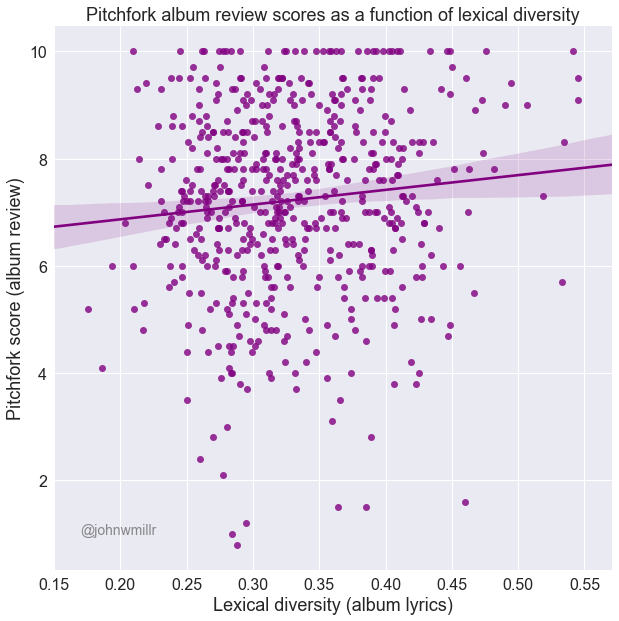

In [207]:
# Plot review score as a function of lexical diversity
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x=album_lexdivs, y=album_scores, ax=ax, color='purple', label='Album')
ax.set_xlabel("Lexical diversity (album lyrics)", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
ax.annotate("@johnwmillr", (0.17,1), fontsize=FS-4, alpha=0.5)
# ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)
# fig.savefig("./figures/pitchfork_score_vs_lexdiv_v2.png", format="png", dpi=300, bbox_inches="tight")
plt.show()